# Speech Text Sentiment Model Finetuning 3Class Text Classification using the Trainer API
The Transformers library provides a lot of useful resources, like the common datasets used for various nlp tasks, and also the Trainer class, which makes the codes for fine-tuning much shorter.

## preparation - Set up

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# To try to fine tune tinybert model

Version 1 (28 August 2024):
build dataset on tinybert.   
Version 2 (1st Sept 2024):  


Benchmark models here:
1. [default-distilbert-finetune-on-sst](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english/tree/main)
2. [distilbert-finetune-on-imda](https://huggingface.co/lvwerra/distilbert-imdb)
Both of them are binary classificaiton.
3. [tine-bert](https://huggingface.co/AdamCodd/tinybert-sentiment-amazon)


finetune dataset:
1. [Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2)  extract from movie reviews, much short text content
2. [imda](https://huggingface.co/datasets/stanfordnlp/imdb) movie reviews

## data load

In [ ]:
import pathlib
import textwrap

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.simplefilter(action='ignore') # mute warnings

import json
import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
import pandas as pd

data_df = pd.read_csv('/content/drive/MyDrive/PLP/text_model_ZY/IMDA_all_for_text_sentiment.csv')
data_df.head()

,session_id,x_min,speaker_id,speaker_type,dialog_type,cleaned_text_for_sentiment,word_count,rule_based_label,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,1.0,18.58958,3002.0,client,holiday,one of the adult is wheelchair bound which is ...,13.0,neutral,True,0.0000,0.100000,0.0,0.033333,-0.15,negative,False,-0.113333,negative
1,1.0,25.79000,3002.0,client,holiday,my spouse and myself and my two children and (...,11.0,neutral,True,0.3612,0.000000,0.0,0.120400,0.00,neutral,True,0.036120,neutral
2,1.0,32.49143,3002.0,client,holiday,first for the air airplane right I would like ...,16.0,neutral,False,0.3612,0.058929,-0.8,-0.126624,0.15,neutral,True,0.150000,neutral
3,1.0,41.16000,3002.0,client,holiday,to the toilet so it s more convenient for my (...,9.0,negative,False,0.0000,0.100000,-1.0,-0.300000,0.30,neutral,False,0.300000,neutral
4,1.0,46.47164,3002.0,client,holiday,parent and also my kids because you know the t...,16.0,neutral,True,0.0000,0.000000,0.0,0.000000,0.30,neutral,True,0.210000,neutral


In [ ]:
# take first around 120 session id as test set
testset_df =  data_df[ (data_df.session_id>=683) & (data_df.session_id<=800)]
trainset_df = data_df[~((data_df.session_id >= 683) & (data_df.session_id <= 800))]

trainset_df = trainset_df.reset_index(drop=True)

testset_df['final_sentiment_label'].value_counts(), trainset_df['final_sentiment_label'].value_counts()

(final_sentiment_label
 neutral     10372
 positive     3524
 negative     2093
 Name: count, dtype: int64,
 final_sentiment_label
 neutral     163097
 positive     88631
 negative     34220
 Name: count, dtype: int64)

In [ ]:
data_df.word_count.max(),data_df.word_count.min()

(53.0, 7.0)

In [ ]:
df = trainset_df[['cleaned_text_for_sentiment','final_sentiment_label']]
df.columns = ['text','label']

def encode_sentiment_label(label):
    if label == 'negative':
        return 0
    elif label == 'neutral':
        return 1
    else:
        return 2

df['label'] = df['label'].apply(encode_sentiment_label)
# df.head()

In [ ]:
import re

def clean_text_for_word_count(text):
    # Ensure the input is a string, otherwise return an empty string
    if not isinstance(text, str):
        return ''
    # Remove any string in brackets like (<xxx>) or [<xxx>] or <<xxx>>
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\<.*?\>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove specific markers <B>, <S>, <Z>
    # text = re.sub(r'<B>|<S>|<Z>', '', text)
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', text).strip()

    return cleaned_text

df['text'] = df['text'].apply(clean_text_for_word_count)
df['text'].head(10)

,text
0,one of the adult is wheelchair bound which is ...
1,my spouse and myself and my two children and I...
2,first for the air airplane right I would like ...
3,to the toilet so it s more convenient for my
4,parent and also my kids because you know the t...
5,so you know elderly they may may not be able t...
6,handicap friendly do they have facility like l...
7,and you know the restaurant is it also okay fo...
8,we also want to have some places for them you ...
9,okay alright so miss lily thank you again for ...


In [ ]:
subset_size = 50000
neutral_sample = df[df['label'] == 1].sample(n=int(subset_size), random_state=42)
positive_sample = df[df['label'] == 2].sample(n=int(subset_size), random_state=42)
negative_sample = df[df['label'] == 0].sample(n=subset_size, random_state=42,replace=True)

balanced_df= pd.concat([neutral_sample, positive_sample, negative_sample]).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
1    50000
2    50000
0    50000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Convert the pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
df_test = testset_df[['cleaned_text_for_sentiment','final_sentiment_label']]
df_test.columns = ['text','label']
df_test['label'] = df_test['label'].apply(encode_sentiment_label)
df_test['text'] = df_test['text'].apply(clean_text_for_word_count)

subset_size2 = 2500
neutral_sample = df_test[df_test['label'] == 1].sample(n=int(subset_size2), random_state=42)
positive_sample = df_test[df_test['label'] == 2].sample(n=int(subset_size2), random_state=42)
negative_sample = df_test[df_test['label'] == 0].sample(n=subset_size2, random_state=42,replace=True)

balanced_df_test= pd.concat([neutral_sample, positive_sample, negative_sample]).reset_index(drop=True)
test_dataset_final = Dataset.from_pandas(balanced_df_test)

## tinybert

In [ ]:
from transformers import AutoTokenizer
# Load the tokenizer for 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

# Define a function to tokenize the dataset
def tokenize_function(examples):
    texts = examples['text'] if isinstance(examples['text'], list) else [examples['text']]
    return tokenizer(texts, padding='max_length', truncation=True, max_length=64)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model for sequence classification with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=3)
# Make sure model weights are contiguous
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',                # Output directory for model predictions and checkpoints
    evaluation_strategy='epoch',           # Evaluate the model at the end of each epoch
    learning_rate=2e-5,                    # Learning rate
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=3,                    # Number of training epochs
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='./logs',                  # Directory for storing logs
    logging_steps=1000,                      # Log every 10 steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                           # The model to be trained
    args=training_args,                    # Training arguments
    train_dataset=tokenized_train_dataset, # Training dataset
    eval_dataset=tokenized_test_dataset    # Evaluation dataset
)
import time
start = time.time()
# Train the model
trainer.train()
end = time.time()
print("tinybert model training time: ", round(end-start,3), " seconds. ")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.785800,0.764299
2,0.744700,0.744030
3,0.731900,0.739133


tinybert model training time:  339.153  seconds. 


In [ ]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

print(f"Evaluation results: {eval_results}")



Evaluation results: {'eval_loss': 0.739132821559906, 'eval_runtime': 12.0269, 'eval_samples_per_second': 2494.41, 'eval_steps_per_second': 155.901, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Predict on the training dataset
train_predictions = trainer.predict(tokenized_train_dataset)
train_accuracy = compute_metrics(train_predictions)['accuracy']
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
test_predictions = trainer.predict(tokenized_test_dataset)
test_accuracy = compute_metrics(test_predictions)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6971


Test Accuracy: 0.6807


In [ ]:
tokenized_test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)
# Predict on the test dataset
test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Test Accuracy: 0.6065


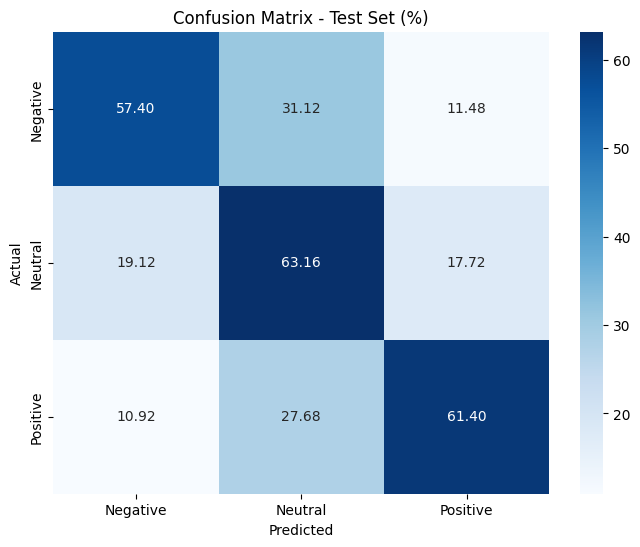

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Get predictions and true labels for the training set
# train_predictions = trainer.predict(tokenized_train_dataset)
# train_preds = train_predictions.predictions.argmax(-1)  # Convert logits to predicted labels
# train_labels = train_predictions.label_ids  # True labels

# Get predictions and true labels for the test set
# test_predictions = trainer.predict(tokenized_test_dataset)
test_preds = test_predictions_final.predictions.argmax(-1)
test_labels = test_predictions_final.label_ids

# Plot confusion matrix for training set with percentages
# plot_confusion_matrix_percentage(train_labels, train_preds, title='Confusion Matrix - Training Set (%)')

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')

In [ ]:
from sklearn.metrics import classification_report

# Print classification report for training set
print("Classification Report - Training Set")
print(classification_report(train_labels, train_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Print classification report for test set
print("Classification Report - Test Set")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report - Training Set
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76     40013
     Neutral       0.63      0.62      0.62     40070
    Positive       0.71      0.71      0.71     39917

    accuracy                           0.70    120000
   macro avg       0.70      0.70      0.70    120000
weighted avg       0.70      0.70      0.70    120000

Classification Report - Test Set
              precision    recall  f1-score   support

    Negative       0.66      0.57      0.61      2500
     Neutral       0.52      0.63      0.57      2500
    Positive       0.68      0.61      0.64      2500

    accuracy                           0.61      7500
   macro avg       0.62      0.61      0.61      7500
weighted avg       0.62      0.61      0.61      7500



In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all')
tokenizer.save_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all')

('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all/tokenizer_config.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all/special_tokens_map.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all/vocab.txt',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all/added_tokens.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all/tokenizer.json')

## try distillbert

In [ ]:
from transformers import TrainingArguments, Trainer
from accelerate import Accelerator
from transformers import AutoModelForSequenceClassification

accelerator = Accelerator()
device = accelerator.device

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the tokenizer for 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=80)

# Apply the tokenizer to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Load DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Define the compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results',             # Output directory for model predictions and checkpoints
    evaluation_strategy='epoch',        # Evaluate every epoch
    learning_rate=2e-5,                 # Learning rate
    per_device_train_batch_size=16,     # Batch size for training
    per_device_eval_batch_size=16,      # Batch size for evaluation
    num_train_epochs=3,                 # Number of epochs
    weight_decay=0.01,                  # Strength of weight decay
    logging_dir='./logs',               # Directory for storing logs
    logging_strategy='epoch',           # Log at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=tokenized_train_dataset,  # Training dataset
    eval_dataset=tokenized_test_dataset,     # Evaluation dataset
    tokenizer=tokenizer,                 # The tokenizer used to preprocess the data
    data_collator=data_collator,         # The data collator for padding
    compute_metrics=compute_metrics      # Function to compute metrics
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model epoch at 3
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.688100,0.633227,0.728900,0.730655,0.733997,0.728900


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.688100,0.633227,0.728900,0.730655,0.733997,0.728900
2,0.547800,0.617835,0.744333,0.743338,0.742911,0.744333
3,0.437000,0.644186,0.752367,0.751941,0.751567,0.752367


Evaluation results: {'eval_loss': 0.6441859602928162, 'eval_accuracy': 0.7523666666666666, 'eval_f1': 0.7519405684420181, 'eval_precision': 0.7515665524645, 'eval_recall': 0.7523666666666666, 'eval_runtime': 71.5642, 'eval_samples_per_second': 419.204, 'eval_steps_per_second': 26.2, 'epoch': 3.0}


In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all')
tokenizer.save_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all')

('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all/tokenizer_config.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all/special_tokens_map.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all/vocab.txt',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all/added_tokens.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all/tokenizer.json')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Predict on the training dataset
train_predictions = trainer.predict(tokenized_train_dataset)
train_accuracy = compute_metrics(train_predictions)['accuracy']
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
test_predictions = trainer.predict(tokenized_test_dataset)
test_accuracy = compute_metrics(test_predictions)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy Final: {test_accuracy:.4f}")

Training Accuracy: 0.8332


Test Accuracy: 0.7197


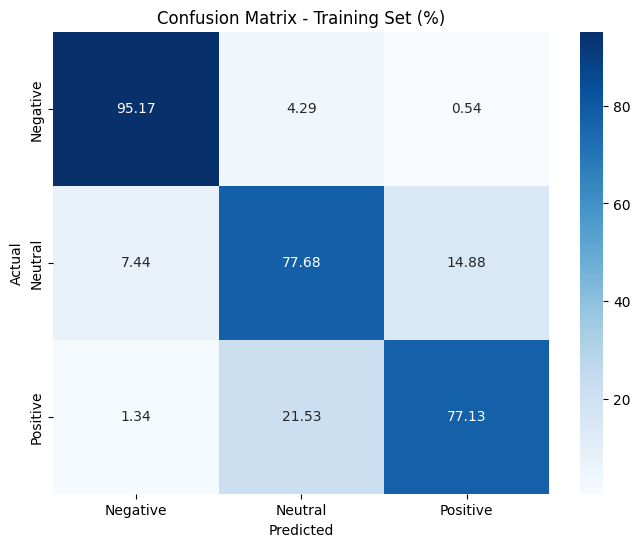

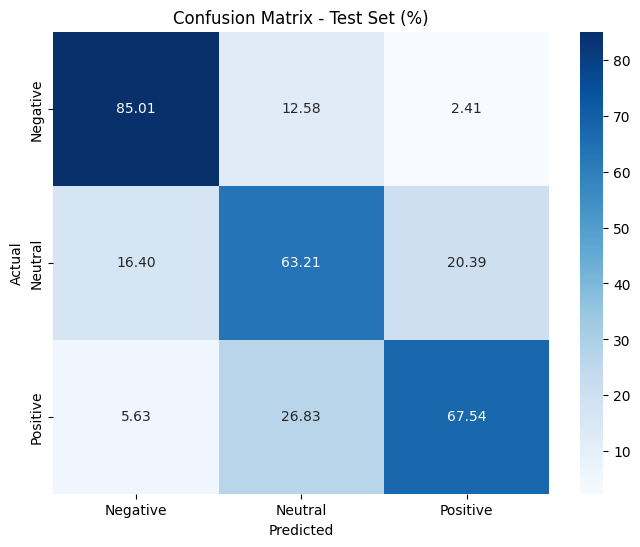

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Get predictions and true labels for the training set
# train_predictions = trainer.predict(tokenized_train_dataset)
train_preds = train_predictions.predictions.argmax(-1)  # Convert logits to predicted labels
train_labels = train_predictions.label_ids  # True labels

# Get predictions and true labels for the test set
# test_predictions = trainer.predict(tokenized_test_dataset)
test_preds = test_predictions_final.predictions.argmax(-1)
test_labels = test_predictions_final.label_ids

# Plot confusion matrix for training set with percentages
plot_confusion_matrix_percentage(train_labels, train_preds, title='Confusion Matrix - Training Set (%)')

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')

## reload model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all')

In [ ]:
# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# Apply the tokenizer to the dataset
# tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
# tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the training arguments (required for evaluation)
training_args = TrainingArguments(
    output_dir='./results',               # Output directory
    per_device_eval_batch_size=16,        # Batch size for evaluation
    logging_dir='./logs',                 # Directory for storing logs
)

# Initialize the Trainer for evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_test_dataset_final
)

# Evaluate the model
eval_result = trainer.evaluate()

In [ ]:
print(f"Evaluation results: {eval_result}")

Evaluation results: {'eval_loss': 1.0168172121047974, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 19.1355, 'eval_samples_per_second': 391.941, 'eval_steps_per_second': 24.509}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# # Predict on the training dataset
# train_predictions = trainer.predict(tokenized_train_dataset)
# train_accuracy = compute_metrics(train_predictions)['accuracy']
# print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
# test_predictions = trainer.predict(tokenized_test_dataset)
# test_accuracy = compute_metrics(test_predictions)['accuracy']
# print(f"Test Accuracy: {test_accuracy:.4f}")

test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy Final: {test_accuracy:.4f}")

Test Accuracy Final: 0.6315


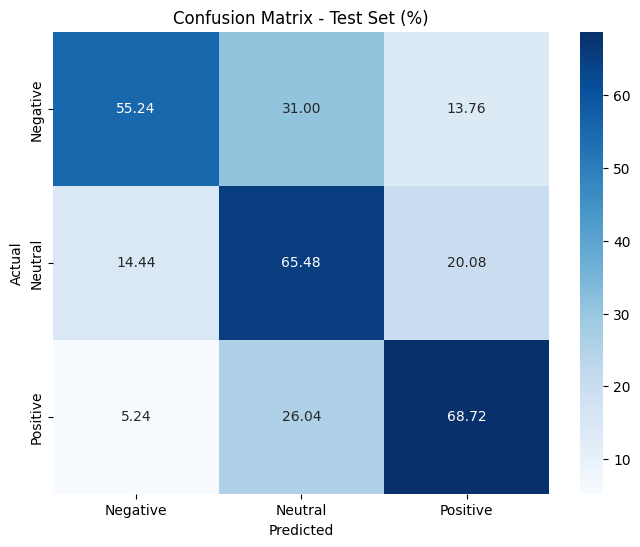

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


# Get predictions and true labels for the test set
# test_predictions = trainer.predict(tokenized_test_dataset)
test_preds = test_predictions_final.predictions.argmax(-1)
test_labels = test_predictions_final.label_ids

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')